Initial code from https://github.com/OnbyshAlex/Brazilian-coin-classification. I just made the adjusts to run the notebook code in Kaggle, extracting the classification dataset from tar.gz file. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
filepath = '/gdrive/My Drive/Brazilian-coin-classification-master/'
path = '/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/'

Mounted at /gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf
import random

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization


Kaggle has a number of files constraint and extract all the files from the tar.gz file creates more files than Kaggle supports. The workaround for this limitation is to extract the individual files, process the file and remove it. 

In [ ]:

def load_images_from_folder(folder):
    image_list = []
    label_list = []
    for filename in os.listdir(folder):
        if(filename[-4:] == '.jpg'):
            print(os.path.join(folder,filename))
            image_list.append(np.array(cv2.imread(os.path.join(folder,filename), cv2.IMREAD_COLOR)))
            label_list.append(filename.split('_')[0])
            # img = cv2.imread(os.path.join(folder,filename))
    return image_list,label_list

folder=path


image_list,label_list = load_images_from_folder(folder)

images = np.array(image_list)
labels = np.array(label_list)


/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477193112.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477282704.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477139796.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477283310.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477192782.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477144608.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477283202.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477144536.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_dataset/all/all/50_1477282002.jpg
/gdrive/My Drive/Brazilian-coin-classification-master/classification_data

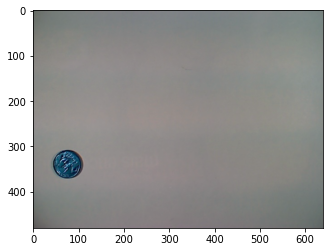

In [ ]:
plt.imshow(images[2700])

In [ ]:
print(images.shape, labels.shape)

(3059, 480, 640, 3) (3059,)


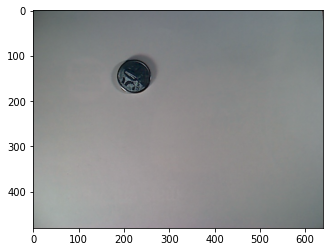

In [ ]:
plt.imshow(images[10])

In [ ]:
def extract_coins(img, to_size=100):
    """

    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)
        

        frames.append(resized)
        # print(resized.shape)
        # cropimg = cropimg.append(resized)
    return np.array(frames), radiuses

In [ ]:
scaled = []
scaled_labels = []
radiuses = []
for nominal, image in zip(labels, images):
    prepared, radius = extract_coins(image)
    # print(prepared.shape)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)
        radiuses.append(radius[0])

# # Create dataframe with data and pickle it
# data = pd.DataFrame({'label': scaled_labels, 'radius': radiuses, 'image': scaled})

# data.to_pickle(filepath + 'filenew.pickle')

Run the code bellow to reload pickle file...

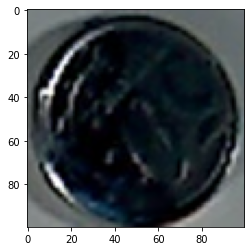

In [ ]:
# Load data
data = pd.read_pickle(filepath + 'filenew.pickle')
plt.imshow(scaled[4])

In [ ]:
data

,label,radius,image
0,50,39.200001,"[[[132, 137, 135], [133, 138, 136], [133, 138,..."
1,50,37.200001,"[[[129, 134, 133], [129, 134, 133], [129, 134,..."
2,50,43.400002,"[[[151, 146, 147], [151, 147, 146], [151, 147,..."
3,50,37.400002,"[[[122, 126, 127], [122, 126, 127], [122, 126,..."
4,50,35.599998,"[[[122, 130, 130], [122, 130, 130], [122, 130,..."
...,...,...,...
3033,100,42.799999,"[[[144, 139, 140], [144, 139, 140], [143, 139,..."
3034,100,46.400002,"[[[121, 120, 116], [121, 120, 116], [122, 121,..."
3035,100,42.799999,"[[[128, 134, 129], [128, 134, 129], [128, 134,..."
3036,100,43.400002,"[[[142, 137, 138], [142, 137, 138], [142, 137,..."


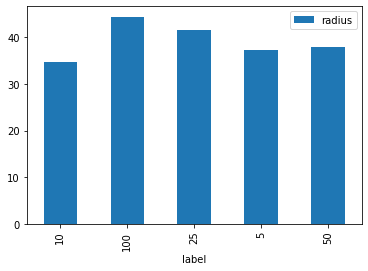

In [ ]:
# Radiuses distribution
data.groupby('label').mean().plot.bar()

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.radius.values, data.label.values, test_size=0.20, random_state=42)
print(X_test.shape,X_train.shape)
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
print(X_test.shape,X_train.shape)

(608,) (2430,)
(608, 1) (2430, 1)


In [ ]:
radius_value = 42
data.image.values[1].shape

# for i, radius in enumerate(data.radius.values):
#   if radius == radius_value:
#     plt.imshow(data.image.values[i])
#     plt.show()

(100, 100, 3)

In [ ]:
clf = SVC(verbose=True,max_iter=1000)
clf.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [ ]:
clf.score(X_test, y_test)

0.5773026315789473

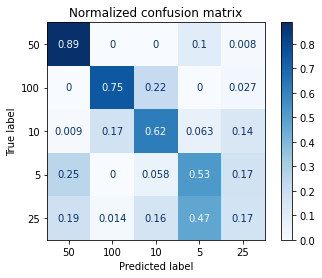

In [ ]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
np.set_printoptions(precision=1)
titles_options = [
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels={'25', '5', '50', '100', '10'},
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

In [ ]:
# print(X_test[2].reshape(608,))
y_pred = clf.predict(X_test)
print(y_pred)
print(X_test)

['5' '100' '5' '100' '10' '5' '10' '25' '5' '25' '5' '10' '5' '100' '5'
 '5' '50' '10' '100' '25' '25' '5' '50' '10' '5' '10' '50' '10' '5' '25'
 '25' '10' '25' '10' '5' '5' '5' '5' '5' '25' '50' '5' '10' '25' '5' '100'
 '25' '100' '5' '10' '25' '25' '25' '25' '25' '100' '25' '100' '50' '10'
 '100' '100' '10' '10' '100' '50' '50' '25' '5' '50' '10' '25' '5' '5'
 '25' '10' '10' '5' '50' '100' '5' '25' '5' '25' '100' '5' '10' '10' '10'
 '100' '100' '10' '10' '5' '10' '5' '10' '5' '100' '100' '5' '10' '10'
 '50' '10' '25' '10' '50' '25' '10' '5' '10' '5' '10' '100' '5' '5' '5'
 '10' '25' '25' '10' '50' '25' '10' '10' '5' '10' '10' '25' '100' '50'
 '10' '50' '5' '5' '5' '25' '10' '10' '5' '10' '10' '10' '5' '100' '5' '5'
 '10' '25' '5' '5' '100' '50' '10' '10' '10' '50' '100' '25' '25' '10'
 '100' '10' '10' '5' '10' '10' '25' '10' '25' '100' '25' '5' '100' '100'
 '10' '10' '5' '10' '10' '5' '100' '25' '5' '5' '5' '25' '10' '5' '25'
 '100' '50' '25' '5' '100' '25' '100' '100' '50' '10' '5' 

In [ ]:
clf

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          10       0.89      0.66      0.76       168
         100       0.75      0.80      0.78       106
          25       0.62      0.56      0.59       123
           5       0.53      0.42      0.47       149
          50       0.17      0.37      0.23        62

    accuracy                           0.58       608
   macro avg       0.59      0.56      0.56       608
weighted avg       0.65      0.58      0.60       608



# **CNN**

In [ ]:
model.load_weights(filepath+"model1.h5")

In [ ]:
# Convert the string labels to int
print(np.array(scaled_labels).shape)
print(set(scaled_labels))
label_classes = set(scaled_labels)

labels_dict = {}
for v_i, v in enumerate(label_classes):
    labels_dict[v] = v_i
        
print(labels_dict)

labels = []
for label in scaled_labels:
    labels.append(labels_dict[label])
    
print(set(labels))    

y_binary = to_categorical(labels)
print(labels)
print(y_binary)

(3038,)
{'50', '100', '10', '5', '25'}
{'50': 0, '100': 1, '10': 2, '5': 3, '25': 4}
{0, 1, 2, 3, 4}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    np.array(scaled), y_binary, test_size=0.15, shuffle= True)

In [ ]:
# input_shape=(100, 100, 3)
# num_classes = 5
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

In [ ]:
print(x_train.shape)

(2582, 100, 100, 3)


In [ ]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


NameError: ignored

In [ ]:
# model.fit(
#     x=x_train,
#     y=y_train,
#     epochs=10,
#     batch_size=500,
#     verbose=1                  # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
# )

In [ ]:
loss, accuracy = model.evaluate(x_valid, y_valid, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
# model.save(filepath+"model1.h5")

In [ ]:
# model.load_weights(filepath+"model1.h5")
# evaluate loaded model on test data
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
# Function to plot confusion matrix  
np.set_printoptions(precision=2)  
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    # plt.text(j, i, "{:0.2f}".format(cm[i, j]),
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
# Predict the values from the validation dataset
Y_pred = model.predict(x_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(5)) 


In [ ]:
plot_confusion_matrix(confusion_mtx, classes = range(5)) 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_pred_classes,Y_true))

# **MLP**

In [ ]:
# Split the data into train and test sets
X_trainmlp, X_testmlp, y_trainmlp, y_testmlp = train_test_split(data.radius.values, 
                                              data.label.values, test_size=0.20, random_state=42)
X_trainmlp, X_testmlp = X_trainmlp.reshape(-1, 1), X_testmlp.reshape(-1, 1)

In [ ]:
from sklearn.neural_network import MLPClassifier 

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100, ),batch_size=500,
                    learning_rate_init=0.0001,max_iter=120000, verbose=1, tol=0.00001)

In [ ]:
mlp.fit(X_trainmlp,y_trainmlp)

In [ ]:
mlp.score(X_testmlp,y_testmlp)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
mlp.predict(X_testmlp)

In [ ]:
radius_value = 39
for i, radius in enumerate(data.radius.values):
  if radius == radius_value:
    plt.imshow(data.image.values[i])
    plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mlp, X_testmlp, y_testmlp,
                                 display_labels=labels_dict,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

In [ ]:
y_predmlp = clf.predict(X_testmlp)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_predmlp,y_testmlp))